# Bayesian Optimization: Searching for the global minima
**You should hand in a report, via Canvas, maximum 6 pages (excluding references). 
Do not attach any appendices. In the report you should present your data, models and the final results.
Do not forget to visualize your data and results.
It is important that you discuss your findings and reflect on the results.
In addition you need to hand in your Python code.
The code itself will not be graded, but it should run without errors and upon inspection reproduce the main results you present in the report.
Emphasis will be put on your ability to use appropriate terminology to describe and discuss the employed statistical methodologies and results.**

**<font color=red>DEADLINE: Dec 10 (Tuesday), 23:59</font>**

## Background
In this project you will explore and search the potential energy surface (PES) for an Au atom placed on top of a Au surface.
We will use a gold surface with Miller indices (433), which is so-called vicinal surface, corresponding to stepped (111) surface.
The Au atom  placed ontop of the surface is refered to as an ad-atom.

<img src="images/surface_433.png" alt="Drawing" style="width: 850px;"/>

Here the left image shows a side view of the surface with the ad-atom colored in red.
The right image shows the top view ($z$-direction) of the surface with the primitive cell marked as the smaller rectangle drawn in black.

Finding the position of the ad-atom with the lowest energy is a difficult problem as there are multiple local minima in the PES.
Furthermore, evaluating the potential energy is commonly done with density functional theory (DFT) which is very computationally expensive and hence it is desirable to keep the number of potential energy calculations as low as possible.
To tackle these two problems we will employ Bayesian optimization using Gaussian Processes.

Additional information on a very similar task can be found in the [paper by Todorovic *et al.*](https://doi.org/10.1038/s41524-019-0175-2), a copy of which (`Todorovic-2019.pdf` is included in this directory).

## Atomstic structure
Here, instead of DFT, we will use an embedded medium theory calculator which is provided in [`ase`](https://wiki.fysik.dtu.dk/ase/index.html) or [`asap`](https://wiki.fysik.dtu.dk/asap).
You are given a atomistic surface in `structures/surface_supercell.xyz`, which can be read as
``` python
from ase.io import read
surface = read('structures/surface_supercell.xyz')
```
When searching for the optimal location of the ad-atom we only need to consider positions inside the primitive cell since the PES will be repeating itself if we move outside the primitive cell.
We therefore only consider position in the domain
\begin{equation}
0 < x < 16.65653 \quad  \land \quad 0 < y < 2.884996
\end{equation}


## Evaluating the PES
The ad-atom energy of interest, $E$, is defined as by
\begin{equation}
E = E_\text{ad} - E_\text{surface},
\end{equation}
where $E_\text{ad}$ is the potential energy of the system with the ad-atom present and $E_\text{surface}$ the energy of just the bare surface system.
When evaluating the PES, we consider the surface to be completly rigid and only allow the ad-atom to move.
The energy can thus be written as 
\begin{equation}
E = E(x,y,z),
\end{equation}
where $(x,y,z)$ corresponds to the position of the ad-atom.
Here, we will allow the $z$-coordinate of the ad-atom to relax to its local minima (given $x$ and $y$) and thus only consider the $x-y$ dependency of the energy, meaning we write the energy $E$ as
\begin{equation}
E(x, y) = \min_z E(x, y, z).
\end{equation}
The primary goal of this project is to find the global minimum of the function $E(x, y)$ in as few evaluations of $E(x, y)$ as possible.


## Bayesian Optimization
To this end, we turn to Bayesian optimization using Gaussian processes (GPs).
The idea is to iteratively train a GP to model the energy, $E(x, y)$, and use it to suggest new possible samples.

Let $\mathbf{X}$ be an array of shape $(N, 2)$ containing $(x, y)$ points as rows and $\boldsymbol{E}$ an array of length $N$ with energies corresponding to $E(x,y)$ for each point in $\mathbf{X}$.
First we construct an initial model from a few randomly drawn samples $\mathbf{X}$ and their corresponding energies $\boldsymbol{E}$.       
This allows us to train a GP for the given $\mathbf{X}$ and $\boldsymbol{E}$, which provides both an average value $\mu$ and a standard deviation $\sigma$ for the energy at $(x, y)$.

The next step is to select a new point $(x_\text{new},y_\text{new})$ for sampling.
This is done by finding the point $(x_\text{new},y_\text{new})$ in the domain that maximizes the so-called acquisition function $A(x, y)$.
In this project, we recommend using the lower confidence  bound (LCB) acquisition function, which is defined as 
\begin{equation}
A(x, y) = -\mu (x, y) + \beta \sigma (x,y).
\end{equation}
Here, $\beta$ is a hyperparameter that can be chosen approximately from the range 1 to 5.
A large value of $\beta$ will favor more exploration whereas a smaller value will lead to more exploitation.
* **Exploitation:** Search regions with low mean (low energy)
* **Exploration:** Search regions with high uncertainty/variance
You can also adaptively adjust $\beta$ during the Bayesian optimization.
Can you think of suitable protocols?

A new data point can thus be selected by
\begin{equation}
(x_\text{new}, y_\text{new}) = \arg \max_{x, y} A(x, y)
\end{equation}
Next the energy at this new point, $E(x_\text{new}, y_\text{new})$, is evaluated and added to our samples $\mathbf{X}$ and $\boldsymbol{E}$.
This allows a new GP model to be trained and we can iterate through this procedure until convergence is (hopefully) reached.


## GPy optimization
Setting up your GP model can be achieved using a snippet such as the following
```python
k1 = GPy.kern.RBF(input_dim=2)
k2 = GPy.kern.Bias(input_dim=2)
kernel = k1 + k2
model = GPy.models.GPRegression(x_data, y_data, kernel)
model.optimize()
print(model)
```
Where `model.optimize` will find the variance, length scale and bias that maximizes the log-likelihood for the GP.
The log-likelihood may be very flat or contain multiple local minima.
In case you end up with strange parameters (such as the lengthscale being $10^{-10}$ or $10^{10}$), it can help to rerun the optimization a few times which can automatically be done via
``` python
model.optimize_restarts()
```
Additionaly, it might help to put some reasonable constraints on the parameters, via
```python
k1 = GPy.kern.RBF(input_dim=2)
k1['lengthscale'].constrain_bounded(0.1, 5)
```
Instead of strict constraints, one can also set priors over the parameters via, e.g.,
``` python
k1 = GPy.kern.RBF(input_dim=2)
k1['lengthscale'].set_prior(GPy.priors.Gamma(a=2, b=1))
```

## Helper function for z-relaxation
Below is a helper function that you can use to carry out the relaxation over $z$.
It might be helpful to also define a function only taking $(x, y)$ as argument and setting $z$ to, e.g.,
```python
z = surface.positions[:, 2].max() + 3
```
to make sure the ad-atom sits on top of the surface, and then pass $(x,y,z)$ into `calculate_adatom_energy`.

In [3]:
from ase.constraints import FixAtoms, FixedLine
from ase.optimize import BFGS
from ase import Atom
from asap3 import EMT
# from ase.calculators.emt import EMT


def calculate_adatom_energy(surface, position):
    """Adds adatom to the input surface configuration at the given position
    and relaxes the ad-atoms z-cooridnate.

    Parameters
    ----------
    bare_surface
        surface configuration without adatom
    position
        position (x, y, z) at which to insert adatom in Ångström

    Returns
    -------
    tuple comprising the energy of the adatom configuration
    """
    # add adatom
    surface_with_adatom = surface.copy()
    surface_with_adatom.append(Atom('Au', position))

    # attach calculator
    calc = EMT()
    surface_with_adatom.set_calculator(calc)

    # apply constraints
    constraints = []
    c = FixAtoms(indices=list(range(len(surface_with_adatom) - 1)))
    constraints.append(c)
    c = FixedLine(-1, [0, 0, 1])
    constraints.append(c)

    # relax configuration
    surface_with_adatom.set_constraint(constraints)
    dyn = BFGS(surface_with_adatom, logfile=None)
    dyn.run(fmax=0.02, steps=200)

    energy = surface_with_adatom.get_potential_energy()
    return energy

## Setup
In this project you will need [`ase`](https://wiki.fysik.dtu.dk/ase/index.html), [`asap`](https://wiki.fysik.dtu.dk/asap) and [`GPy`](https://sheffieldml.github.io/GPy/).

In [2]:
import ase
import numpy as np
import GPy
import asap3
import matplotlib.pyplot as plt

In [4]:
# Set some default plotting parameters

plt.rcParams['font.size'] = 15
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 13

## Task 1: Analyzing the PES (1.5p)
The first task of the project will be to generate and visualize the full PES, $E(x, y)$, on a grid for $(x,y)$.
This will give you access to the global minima by visual inspection and will help with understanding, e.g.,  how the optimization algorithms are working or whether they get stuck in the wrong minimum.

This task may take a few minute to run as it requires a lot of evaluations of the PES.

**Tasks:**
* Compute the PES, $E(x, y)$, on a dense grid for $x$ and $y$.
* Visualize the 2D PES as a heatmap.

In [5]:
from ase.io import read
surface = read('structures/surface_supercell.xyz')

In [ ]:
# Define grid boundaries and resolution
number_of_points = 300

x_vals = np.linspace(0, 16.65653, number_of_points)  
y_vals = np.linspace(0, 2.884996, number_of_points)  

# Create a meshgrid
X, Y = np.meshgrid(x_vals, y_vals)

# Evaluate PES
PES = np.zeros_like(X)
z = surface.positions[:, 2].max() + 3

print(f'Initial z: {z}')
# Loop over the grid and calculate the PES
for i in range(X.shape[0]):
    if i % 10 == 0: print(f'Progress: {i / X.shape[0] * 100:.2f}%')
    for j in range(X.shape[1]):
        # Initial guess for z (e.g., 2.5 Å above the surface)
        PES[i, j] = calculate_adatom_energy(surface, [X[i, j], Y[i, j], z])

# Save the PES data for reuse
np.savez('pes_data1.npz', X=X, Y=Y, PES=PES)

Initial z: 24.24644839
Progress: 0.00%
Progress: 3.33%
Progress: 6.67%
Progress: 10.00%
Progress: 13.33%
Progress: 16.67%
Progress: 20.00%
Progress: 23.33%
Progress: 26.67%
Progress: 30.00%
Progress: 33.33%
Progress: 36.67%
Progress: 40.00%
Progress: 43.33%
Progress: 46.67%
Progress: 50.00%
Progress: 53.33%
Progress: 56.67%
Progress: 60.00%
Progress: 63.33%
Progress: 66.67%
Progress: 70.00%
Progress: 73.33%
Progress: 76.67%
Progress: 80.00%
Progress: 83.33%
Progress: 86.67%
Progress: 90.00%
Progress: 93.33%
Progress: 96.67%


In [184]:
#PES = np.load('pes_data.npz')
X, Y, PES = np.load('pes_data.npz').values()

print(np.min(PES))

7.076107904170513


Global minimum at x = 3.2867 Å, y = 0.7237 Å, E = 7.0761 eV


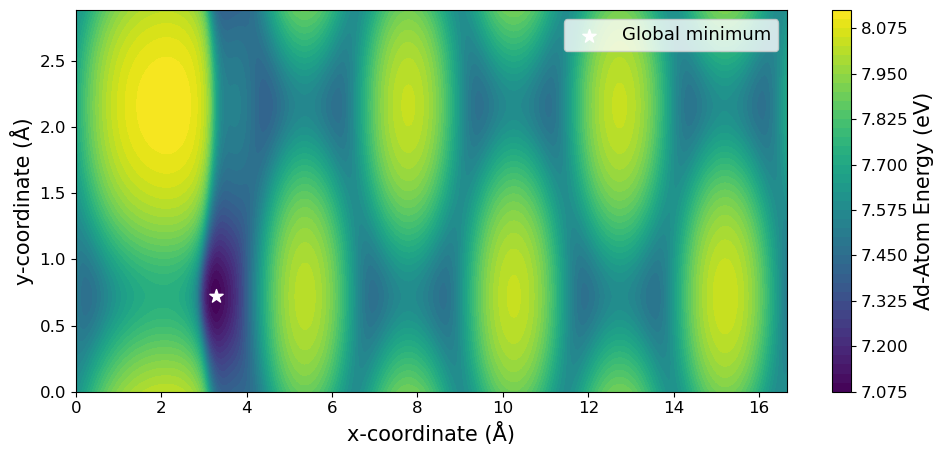

In [ ]:
# Load the PES data
X, Y, PES = np.load('pes_data.npz').values()

# Find the global minimum
min_idx = np.unravel_index(np.argmin(PES), PES.shape)
min_x_t1, min_y_t1 = X[min_idx], Y[min_idx]
print(f"Global minimum at x = {min_x_t1:.4f} Å, y = {min_y_t1:.4f} Å, E = {PES[min_idx]:.4f} eV")

# Plot the PES
plt.figure().set_figwidth(10)
plt.contourf(X, Y,PES, levels = 50, cmap='viridis')
plt.colorbar(label='Ad-Atom Energy (eV)')
plt.scatter(min_x_t1, min_y_t1, c='w', s=100, label='Global minimum',marker='*')
plt.xlabel('x-coordinate (Å)')
plt.ylabel('y-coordinate (Å)')
plt.legend()
plt.tight_layout()
plt.savefig('calc_pes.pdf')
plt.show()

## Task 2: Local search (3p)

In this task you will try out local search (gradient descent) and see how it succeeds or fails for our function $E(x,y)$.

For the local search consider a random starting position uniformly drawn from the $\{x,y\}$ domain.

**Tasks:**
* From visual inspection of the PES in Task 1, can you obtain a rough estimate for the percentage of local searches that would end up in the global minimum.
* Run a few (50-500) local searches and record how many ended up in the global minimum.

*Hint:* `scipy.optimize.minimize` can be used

In [ ]:
from scipy.optimize import minimize

# Define the number of random searches
num_searches = 300
x_starts = np.random.uniform(0, 16.65653, num_searches)
y_starts = np.random.uniform(0, 2.884996, num_searches)

# Define the PES function
def pes_function(position):
    x, y = position
    initial_z = surface.positions[:, 2].max() + 3
    return calculate_adatom_energy(surface, [x, y, initial_z])

# Perform the random searches
results = []
for x0, y0 in zip(x_starts, y_starts):
    result = minimize(pes_function, [x0, y0], method='L-BFGS-B', bounds=[(0, 16.65653), (0, 2.884996)])
    results.append(result)

Success rate: 15.33%
Minimum energy endpoint at x = 3.2591 Å, y = 0.7212 Å, E = 7.0751 eV


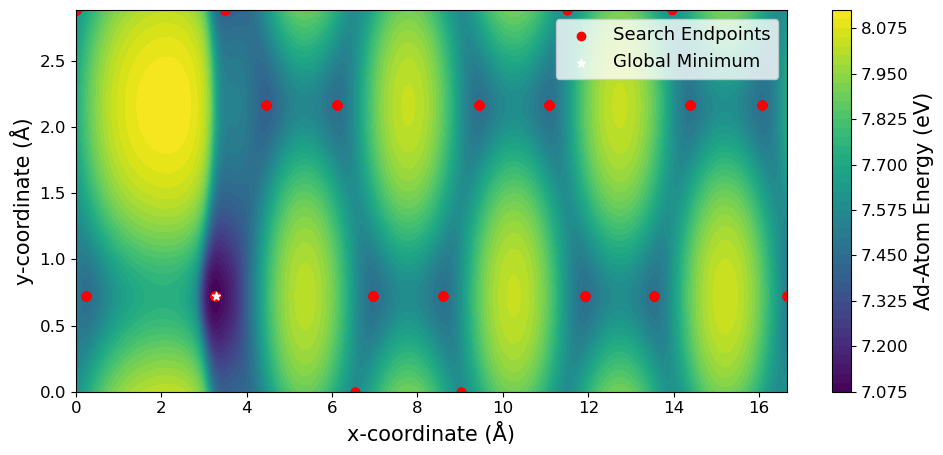

In [ ]:
# Calculate the success rate and global minimum

global_min_coords = [min_x_t1, min_y_t1]
count_global_min = 0
tolerance = 0.5

for result in results:
    if np.linalg.norm(np.array(result.x) - np.array(global_min_coords)) < tolerance:
        count_global_min += 1

success_rate = (count_global_min / num_searches) * 100
print(f"Success rate: {success_rate:.2f}%")

# Extract the endpoints and calculate the energies
x_end = [result.x[0] for result in results]
y_end = [result.x[1] for result in results]

end_points = list(zip(x_end, y_end))

energies = [calculate_adatom_energy(surface,(x, y,z)) for x, y in end_points]
min_energy_idx = np.argmin(energies)

# Find the minimum energy endpoint
min_x_end, min_y_end = end_points[min_energy_idx]
min_energy = energies[min_energy_idx]

print(f"Minimum energy endpoint at x = {min_x_end:.4f} Å, y = {min_y_end:.4f} Å, E = {min_energy:.4f} eV")

plt.figure().set_figwidth(10)
plt.contourf(X, Y, PES, levels=50, cmap='viridis')
plt.colorbar(label='Ad-Atom Energy (eV)')
plt.scatter(x_end, y_end, color='red', label='Search Endpoints')
plt.scatter(min_x_t1,min_y_t1, color='white', label='Global Minimum', marker='*')
plt.xlabel('x-coordinate (Å)')
plt.ylabel('y-coordinate (Å)')
plt.legend()
plt.tight_layout()
plt.savefig('search_endpoints.pdf')
plt.show()

In [60]:
test_energy = pes_function([3.0, 1.0])  # Test a random point
print(f"Energy at (3.0, 1.0): {test_energy:.2f}")

for i, result in enumerate(results[:10]):
    print(f"Search {i+1}: Start = {x_starts[i]:.2f}, {y_starts[i]:.2f}; End = {result.x}; Success = {result.success}")

Energy at (3.0, 1.0): 7.40
Search 1: Start = 14.53, 2.31; End = [14.38596216  2.16374566]; Success = True
Search 2: Start = 12.03, 1.71; End = [11.91622504  0.72125603]; Success = True
Search 3: Start = 2.62, 2.22; End = [4.44613633 2.16374893]; Success = True
Search 4: Start = 9.17, 1.71; End = [9.4419155  2.16374657]; Success = True
Search 5: Start = 5.74, 0.19; End = [6.54447379 0.        ]; Success = True
Search 6: Start = 7.42, 2.25; End = [6.12000353 2.16374717]; Success = True
Search 7: Start = 4.40, 1.20; End = [3.25905911 0.7212476 ]; Success = True
Search 8: Start = 14.99, 1.22; End = [14.38596281  2.16374865]; Success = True
Search 9: Start = 9.03, 0.93; End = [8.59853428 0.72124701]; Success = True
Search 10: Start = 9.73, 1.80; End = [9.4419122  2.16374495]; Success = True


## Task 3: Bayesian optimization (7p)
Implement your own Bayesian optimization algorithm (using GPy for the Gaussian process part) and run it to find the global minima of $E(x, y)$.

Use the [RBF kernel](https://gpy.readthedocs.io/en/deploy/GPy.kern.src.html#module-GPy.kern.src.rbf) and include a Bias kernel if it is needed.

Suitable $\beta$ values might be in the range 1 to 5.

Start the Bayesian optimization from five (5) randomly drawn samples.        


**Tasks:**
* Given the PES in Task 1 choose and motivate priors for the lengthscale and variance parameters in the RBF kernel.
* Run Bayesian optimization and analyze how the choice of $\beta$ influences convergence. Select a good value for $\beta$.
* Rerun bayesian optimization with the selected $\beta$. How many iterations are needed until the global minimum is reached?
* Visualize the PES, the uncertainty ($\sigma$) and the acquisition function together with your samples for the final model.
* In what regions is the final GP model the most uncertain? Why?


*Hints:*
* If your algorithm gets stuck sampling the same points over and over again, try increasing $\beta$ (more exploration).         
* To find the argmax of $A(x, y)$ you can either evaluate it on a very dense grid or run multiple local searches (starting from random positions) and take the maximum obtained.

In [ ]:
# Task 3: Bayesian Optimization
z = surface.positions[:, 2].max() + 3

# Acquisition function: Upper Confidence Bound (UCB)
def acquisition(pt, model, beta):
    """Acquisition function to balance exploration and exploitation."""
    pt = pt.reshape(-1, 2)
    mean, variance = model.predict(pt)
    return -mean + beta * np.sqrt(variance)  

# Main Bayesian optimization function
def bayesian_optimization_final(bounds, n_iterations, beta):
    """Perform Bayesian optimization."""
    # Step 1: Initialize with 5 random points
    num_starting_points = 5

    X = np.random.uniform(bounds[:, 0], bounds[:, 1], (num_starting_points, 2))
    E = np.array([calculate_adatom_energy(surface, [x[0], x[1],z]) for x in X]).reshape(num_starting_points, 1)

    # Step 2: Define kernel and GP model
    k1 = GPy.kern.RBF(input_dim=2)
    k2 = GPy.kern.Bias(input_dim=2)
    
    #k1['lengthscale'].constrain_bounded(0.1, 5)
    k1['lengthscale'].set_prior(GPy.priors.Gamma(a=2, b=1))
    
    kernel = k1 + k2
    
    model = GPy.models.GPRegression(X, E, kernel)
    model.optimize()

    for i in range(n_iterations):
        # Find the next sampling point

        candidate_x = np.random.uniform(bounds[0,0], bounds[0,1], 10000)
        candidate_y = np.random.uniform(bounds[1,0], bounds[1,1], 10000)
        candidates = np.column_stack((candidate_x, candidate_y))

        # Calculate the acquisition function value
        A_values = acquisition(candidates, model, beta=beta)
        x_next = candidates[np.argmax(A_values)]

        #x_next = optimize_acquisition(bounds, model, beta)
        e_next = np.array(calculate_adatom_energy(surface, [x_next[0], x_next[1], z]))

        # Update the data
        X = np.vstack([X, x_next])
        E = np.vstack([E, e_next])
        
        # Update and retrain the GP
        model.set_XY(X, E)
        model.optimize()
        
        print(f"Iteration {i + 1}: x = {x_next}, E(x) = {e_next}")

    # Find the global minimum
    global_minima = {"x": X[np.argmin(E), 0], "y": X[np.argmin(E), 1], "E": np.min(E)}
    print(f"Global minimum at x = {global_minima['x']:.4f} Å, y = {global_minima['y']:.4f} Å, E = {global_minima['E']:.4f} eV")
    return model, X, E

# Visualization of results
def visualize_results(model, X, bounds):
    """Visualize the PES, uncertainty, and acquisition function."""
    # Generate a grid of points for visualization
    x = np.linspace(bounds[0, 0], bounds[0, 1], 500)
    y = np.linspace(bounds[1, 0], bounds[1, 1], 500)
    xx, yy = np.meshgrid(x, y)
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # Predict mean and variance
    mean, variance = model.predict(grid)
    mean = mean.reshape(xx.shape)
    uncertainty = np.sqrt(variance).reshape(xx.shape)
    
    # Plot PES and uncertainty
    plt.figure(figsize=(10,10))
    
    # PES (mean)
    plt.subplot(2, 1, 1)
    plt.contourf(xx, yy, mean, levels=50, cmap="viridis")
    plt.colorbar(label="Mean Prediction (eV)")
    plt.scatter(X[:, 0], X[:, 1], c="red", label="Samples")
    plt.scatter(min_x_end, min_y_end, color='white', label='Global Minimum', marker='*')
    plt.title("Predicted PES")
    plt.xlabel("x-coord (Å)")
    plt.ylabel("y-coord (Å)")
    plt.legend()
    
    # Uncertainty (variance)
    plt.subplot(2, 1, 2)
    plt.contourf(xx, yy, uncertainty, levels=50, cmap="viridis")
    plt.colorbar(label=r"Uncertainty $\sigma$ (eV)")
    plt.scatter(min_x_end, min_y_end, color='white', label='Global Minimum', marker='*')
    plt.title(r"Uncertainty $\sigma$")
    plt.xlabel("x-coord (Å)")
    plt.ylabel("y-coord (Å)")
    plt.legend()

    plt.tight_layout()
    plt.savefig('bayesian_optimization.pdf')
    plt.show()


In [ ]:
# Define bounds and run Bayesian optimization

bounds = np.array([[0, 16.65653], [0, 2.884996]])  # Define bounds for x and y
n_iterations = 500  # Number of iterations
beta = 5.0  # UCB parameter
results_final = {}

print(f"Running Bayesian Optimization for beta = {beta}")
model_final, X_final, E_final = bayesian_optimization_final(bounds, n_iterations, beta)
results_final = {"model": model_final, "X": X_final, "E": E_final}
# Visualize results 

Running Bayesian Optimization for beta = 5.0


reconstraining parameters rbf.lengthscale


Iteration 1: x = [2.50221164 2.70397896], E(x) = 8.057940686725827
Iteration 2: x = [5.40104468e+00 4.87983707e-03], E(x) = 7.8819303018965154
Iteration 3: x = [14.55283536  2.87247947], E(x) = 7.78267776510514
Iteration 4: x = [0.01279426 0.08957438], E(x) = 7.588731442188471
Iteration 5: x = [8.02211542 2.8369924 ], E(x) = 7.899128953982227
Iteration 6: x = [5.0913472  2.85630432], E(x) = 7.845049083447587
Iteration 7: x = [6.92680497 1.26532325], E(x) = 7.61833818901526
Iteration 8: x = [1.72578857 0.03840852], E(x) = 7.996746210602572
Iteration 9: x = [0.03781188 1.50074923], E(x) = 7.630322368673659
Iteration 10: x = [12.39193482  0.04548264], E(x) = 7.84555485617925
Iteration 11: x = [16.62101781  2.08692958], E(x) = 7.679337328437493
Iteration 12: x = [14.98638589  1.24118459], E(x) = 7.964824440082678
Iteration 13: x = [5.7887839 1.5037269], E(x) = 7.796318656484506
Iteration 14: x = [0.05338218 2.83686248], E(x) = 7.633280918642983
Iteration 15: x = [7.52429446e+00 5.50392340e

Bayesian Optimization: Global minimum at x = 3.2610 Å, y = 0.7198 Å, E = 7.0751 eV


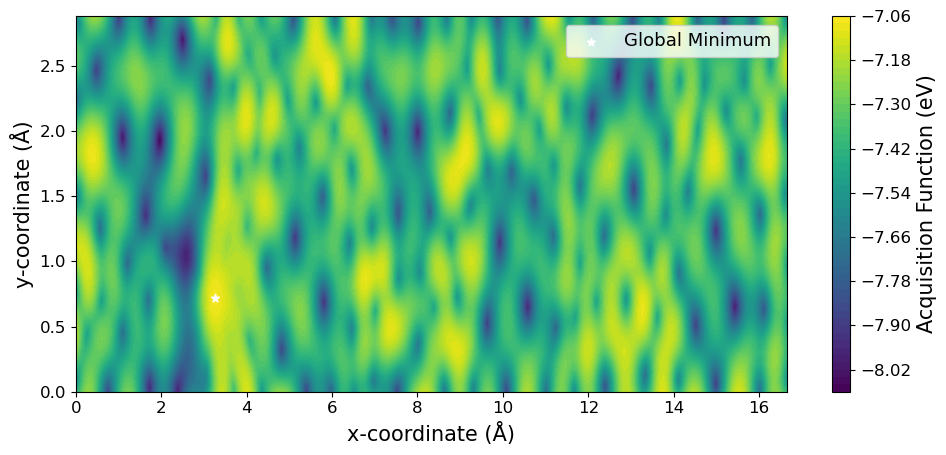

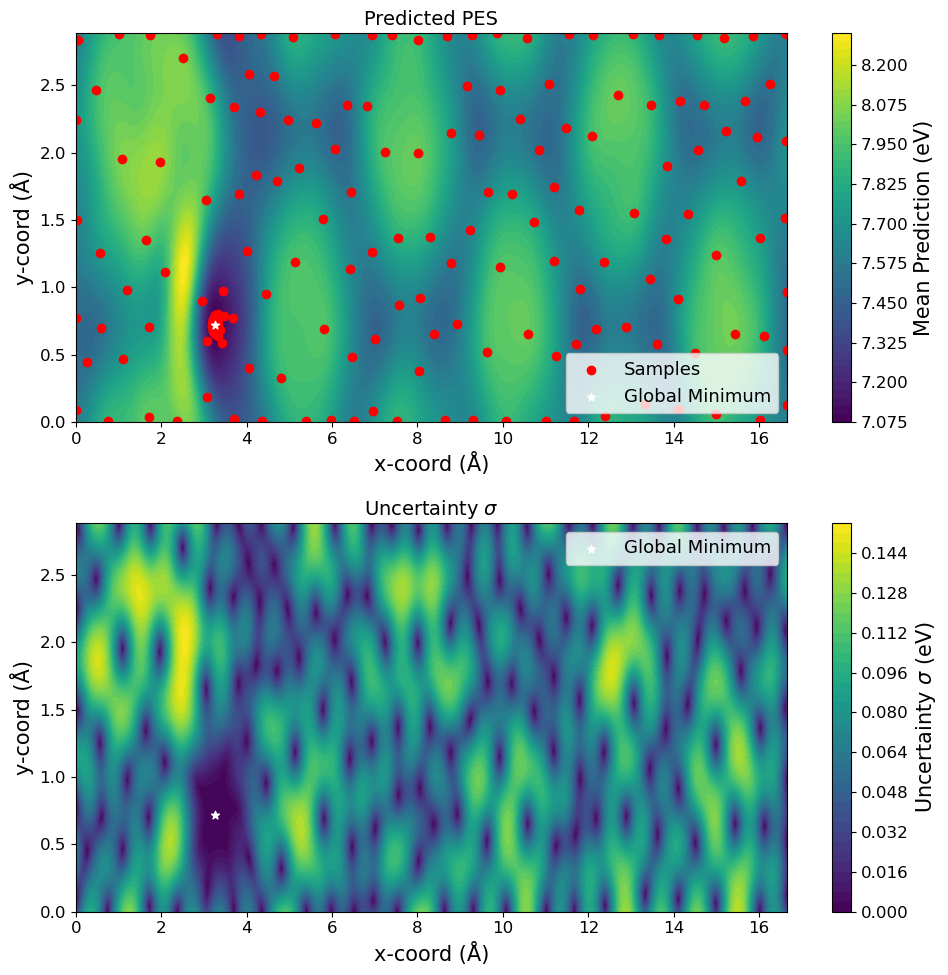

In [ ]:
# Find the global minimum

bay_xmin = X_final[np.argmin(E_final), 0]
bay_ymin = X_final[np.argmin(E_final), 1]
bay_Emin = np.min(E_final)

print(f"Bayesian Optimization: Global minimum at x = {bay_xmin:.4f} Å, y = {bay_ymin:.4f} Å, E = {bay_Emin:.4f} eV")

# Plot the acquisition function
x = np.linspace(bounds[0, 0], bounds[0, 1], 300)
y = np.linspace(bounds[1, 0], bounds[1, 1], 300)
xx, yy = np.meshgrid(x, y)
grid = np.c_[xx.ravel(), yy.ravel()]

A_plot = acquisition(grid, model_final, beta=beta).reshape(xx.shape)

plt.figure().set_figwidth(10)
plt.contourf(xx, yy, A_plot,levels = 50, cmap='viridis')
plt.colorbar(label='Acquisition Function (eV)')
plt.scatter(min_x_end, min_y_end, color='white', label='Global Minimum', marker='*')
plt.xlabel('x-coordinate (Å)')
plt.ylabel('y-coordinate (Å)')
plt.legend()
plt.tight_layout()
plt.savefig('acquisition_function.pdf')
plt.show()

# plot the results
visualize_results(model_final, X_final, bounds)

In [69]:
# save the final results to file
np.savez('bayesian_optimization_results.npz', X=X_final, E=E_final)

In [ ]:
# Task 3: Bayesian Optimization
z = surface.positions[:, 2].max() + 3

# Acquisition function: Upper Confidence Bound (UCB)
def acquisition(pts, model, beta):
    """Acquisition function to balance exploration and exploitation."""
    pts = pts.reshape(-1, 2)
    mean, variance = model.predict(pts)
    return -mean + beta * np.sqrt(variance)  

# Main Bayesian optimization function
def bayesian_optimization(bounds, max_iter, beta):
    """Perform Bayesian optimization."""
    # Step 1: Initialize with 5 random points
    num_starting_points = 5

    X = np.random.uniform(bounds[:, 0], bounds[:, 1], (num_starting_points, 2))
    E = np.array([calculate_adatom_energy(surface, [x[0], x[1],z]) for x in X]).reshape(num_starting_points, 1)

    # Step 2: Define kernel and GP model
    k1 = GPy.kern.RBF(input_dim=2)
    k2 = GPy.kern.Bias(input_dim=2)
    
    #k1['lengthscale'].constrain_bounded(0.1, 5)
    k1['lengthscale'].set_prior(GPy.priors.Gamma(a=2, b=1))
    
    kernel = k1 + k2
    
    model = GPy.models.GPRegression(X, E, kernel)
    model.optimize()

    for i in range(max_iter):

        # Find the next sampling point
        candidate_x = np.random.uniform(bounds[0,0], bounds[0,1], 10000)
        candidate_y = np.random.uniform(bounds[1,0], bounds[1,1], 10000)

        candidates = np.column_stack((candidate_x, candidate_y))

        A_values = acquisition(candidates, model, beta=beta)
        #print(A_values.shape)
        x_next = candidates[np.argmax(A_values)]

        #x_next = optimize_acquisition(bounds, model, beta)
        e_next = np.array(calculate_adatom_energy(surface, [x_next[0], x_next[1], z]))

        # Update the data
        X = np.vstack([X, x_next])
        E = np.vstack([E, e_next])
         
        # Update and retrain the GP
        model.set_XY(X, E)
        model.optimize()
        
    # Find the global minimum
    global_minima = {"x": X[np.argmin(E), 0], "y": X[np.argmin(E), 1], "E": np.min(E)}
    print(f"Global minimum at x = {global_minima['x']:.4f} Å, y = {global_minima['y']:.4f} Å, E = {global_minima['E']:.4f} eV")
    return model, X, E

# Define bounds and run Bayesian optimization for different beta values
bounds = np.array([[0, 16.65653], [0, 2.884996]])  # Define bounds for x and y
max_iter = 100  # Number of iterations
beta_values = np.linspace(1, 5, 5) 
results = {}

# Run Bayesian optimization 25 times for 100 iterations and different beta values 
for beta in beta_values:
    print(f"Running Bayesian Optimization for beta = {beta}")
    for i in range(25):
        model, X_beta, E_beta = bayesian_optimization(bounds, max_iter, beta)
        results[(beta,i)] = {"iteration": i ,"model": model, "X": X_beta, "E": E_beta}

Running Bayesian Optimization for beta = 1.0


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.3441 Å, y = 0.9600 Å, E = 7.1442 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 0.2465 Å, y = 0.7260 Å, E = 7.4580 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 11.9182 Å, y = 0.7160 Å, E = 7.4657 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.1730 Å, y = 0.8727 Å, E = 7.1216 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 11.9147 Å, y = 0.7210 Å, E = 7.4657 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 11.9126 Å, y = 0.7239 Å, E = 7.4657 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 16.0575 Å, y = 2.1634 Å, E = 7.4657 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 0.2488 Å, y = 0.7202 Å, E = 7.4580 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.0216 Å, y = 0.5356 Å, E = 7.2720 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.9713 Å, y = 0.0643 Å, E = 7.4188 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.6925 Å, y = 2.8796 Å, E = 7.4087 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2565 Å, y = 0.7189 Å, E = 7.0752 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 11.9338 Å, y = 0.4606 Å, E = 7.5175 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 6.1179 Å, y = 2.1618 Å, E = 7.4602 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2563 Å, y = 0.7194 Å, E = 7.0752 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2619 Å, y = 0.7157 Å, E = 7.0752 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2740 Å, y = 0.6628 Å, E = 7.0798 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.9070 Å, y = 0.3733 Å, E = 7.3462 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 6.9586 Å, y = 0.7206 Å, E = 7.4616 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.8287 Å, y = 0.0432 Å, E = 7.4045 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.1871 Å, y = 0.7845 Å, E = 7.0891 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2061 Å, y = 0.4895 Å, E = 7.1522 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 11.0736 Å, y = 2.1690 Å, E = 7.4674 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.7117 Å, y = 0.9650 Å, E = 7.2392 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.5766 Å, y = 0.3081 Å, E = 7.2657 eV
Running Bayesian Optimization for beta = 2.0


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2615 Å, y = 0.7220 Å, E = 7.0751 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.1765 Å, y = 0.6246 Å, E = 7.1001 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2610 Å, y = 0.7211 Å, E = 7.0751 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2608 Å, y = 0.7178 Å, E = 7.0752 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 0.2526 Å, y = 0.7225 Å, E = 7.4580 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.1743 Å, y = 1.0625 Å, E = 7.2435 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.1606 Å, y = 1.0737 Å, E = 7.2625 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2586 Å, y = 0.7256 Å, E = 7.0752 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.3517 Å, y = 0.9229 Å, E = 7.1287 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2644 Å, y = 0.7243 Å, E = 7.0752 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2616 Å, y = 0.7245 Å, E = 7.0752 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2620 Å, y = 0.7219 Å, E = 7.0751 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.6926 Å, y = 0.5117 Å, E = 7.2228 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.3209 Å, y = 0.3634 Å, E = 7.2077 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2502 Å, y = 0.7274 Å, E = 7.0753 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.5351 Å, y = 0.8387 Å, E = 7.1458 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 11.1047 Å, y = 2.0073 Å, E = 7.4851 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.1225 Å, y = 0.6437 Å, E = 7.1181 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.3797 Å, y = 0.3224 Å, E = 7.2308 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.3915 Å, y = 0.4906 Å, E = 7.1466 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2667 Å, y = 0.7226 Å, E = 7.0752 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.1683 Å, y = 0.8705 Å, E = 7.1224 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2583 Å, y = 0.7173 Å, E = 7.0752 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2577 Å, y = 0.7187 Å, E = 7.0751 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.6750 Å, y = 0.9118 Å, E = 7.2113 eV
Running Bayesian Optimization for beta = 3.0


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2505 Å, y = 0.7242 Å, E = 7.0752 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 15.9244 Å, y = 2.4643 Å, E = 7.5563 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.0270 Å, y = 0.8573 Å, E = 7.2299 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2576 Å, y = 0.7088 Å, E = 7.0753 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2627 Å, y = 0.7267 Å, E = 7.0752 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2581 Å, y = 0.7216 Å, E = 7.0751 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 8.5460 Å, y = 0.8158 Å, E = 7.4759 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.5562 Å, y = 0.5227 Å, E = 7.1740 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.5953 Å, y = 1.0196 Å, E = 7.2211 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2596 Å, y = 0.7170 Å, E = 7.0752 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.3388 Å, y = 0.2092 Å, E = 7.2999 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2522 Å, y = 0.7231 Å, E = 7.0752 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2581 Å, y = 0.7182 Å, E = 7.0751 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2604 Å, y = 0.7197 Å, E = 7.0751 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2421 Å, y = 0.6112 Å, E = 7.0919 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 4.6798 Å, y = 2.1636 Å, E = 7.4372 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2555 Å, y = 0.7211 Å, E = 7.0752 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2626 Å, y = 0.7282 Å, E = 7.0752 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2612 Å, y = 0.7192 Å, E = 7.0751 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2617 Å, y = 0.7205 Å, E = 7.0751 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2578 Å, y = 0.7217 Å, E = 7.0751 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.7356 Å, y = 0.5494 Å, E = 7.2318 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 4.0603 Å, y = 1.1077 Å, E = 7.4342 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.7902 Å, y = 1.1018 Å, E = 7.3067 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2606 Å, y = 0.7187 Å, E = 7.0751 eV
Running Bayesian Optimization for beta = 4.0


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.9586 Å, y = 0.0720 Å, E = 7.4152 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.8836 Å, y = 0.8128 Å, E = 7.3035 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2628 Å, y = 0.7291 Å, E = 7.0752 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2643 Å, y = 0.7245 Å, E = 7.0752 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2877 Å, y = 0.6975 Å, E = 7.0769 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2648 Å, y = 0.7567 Å, E = 7.0768 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 4.5253 Å, y = 1.9370 Å, E = 7.4449 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2634 Å, y = 0.7218 Å, E = 7.0752 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.0777 Å, y = 0.6083 Å, E = 7.1626 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2533 Å, y = 0.7278 Å, E = 7.0752 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2592 Å, y = 0.7255 Å, E = 7.0752 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 11.1826 Å, y = 1.9898 Å, E = 7.4933 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.3044 Å, y = 0.6982 Å, E = 7.0783 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.4736 Å, y = 0.3183 Å, E = 7.2424 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2563 Å, y = 0.7271 Å, E = 7.0752 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2544 Å, y = 0.7012 Å, E = 7.0757 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2529 Å, y = 0.7243 Å, E = 7.0752 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2462 Å, y = 0.8457 Å, E = 7.0960 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.4194 Å, y = 0.8907 Å, E = 7.1286 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.1675 Å, y = 0.7168 Å, E = 7.0885 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2588 Å, y = 0.7235 Å, E = 7.0751 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 11.1822 Å, y = 2.3200 Å, E = 7.4903 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 4.2423 Å, y = 2.0596 Å, E = 7.4332 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2547 Å, y = 0.7255 Å, E = 7.0752 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2621 Å, y = 0.7215 Å, E = 7.0751 eV
Running Bayesian Optimization for beta = 5.0


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.5057 Å, y = 0.8524 Å, E = 7.1400 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.5738 Å, y = 0.4591 Å, E = 7.2013 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2144 Å, y = 0.7322 Å, E = 7.0782 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2644 Å, y = 0.3948 Å, E = 7.1957 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.3030 Å, y = 0.8466 Å, E = 7.0965 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.4622 Å, y = 0.0379 Å, E = 7.3779 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2051 Å, y = 0.3230 Å, E = 7.2695 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2567 Å, y = 0.7499 Å, E = 7.0762 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.4589 Å, y = 2.8484 Å, E = 7.4097 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.6172 Å, y = 0.6670 Å, E = 7.1648 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2906 Å, y = 0.7265 Å, E = 7.0764 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.3109 Å, y = 0.7365 Å, E = 7.0786 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2780 Å, y = 0.7654 Å, E = 7.0781 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.6051 Å, y = 0.6428 Å, E = 7.1629 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2715 Å, y = 0.7284 Å, E = 7.0754 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2906 Å, y = 0.6423 Å, E = 7.0842 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.4468 Å, y = 1.0838 Å, E = 7.2180 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2212 Å, y = 0.7059 Å, E = 7.0775 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2822 Å, y = 0.7505 Å, E = 7.0769 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.3445 Å, y = 0.7232 Å, E = 7.0831 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.3049 Å, y = 0.7085 Å, E = 7.0778 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.6545 Å, y = 1.0275 Å, E = 7.2406 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.4329 Å, y = 0.9545 Å, E = 7.1553 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2809 Å, y = 0.6938 Å, E = 7.0767 eV


reconstraining parameters rbf.lengthscale


Global minimum at x = 3.2835 Å, y = 0.7504 Å, E = 7.0770 eV


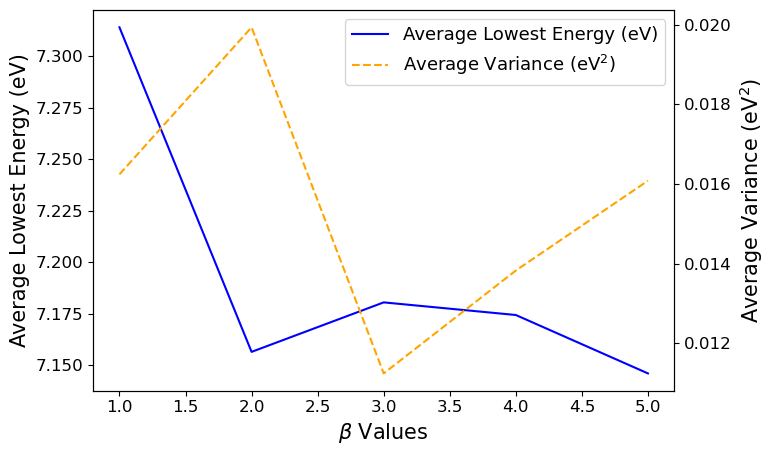

In [ ]:

# Initialize a matrix to hold the lowest energies for each iteration and beta value
lowest_E_matrix = np.zeros((25, len(beta_values)))
average_variances = np.zeros((25, len(beta_values)))

# Iterate over each beta value
for idx, beta in enumerate(beta_values):
    # Iterate over each iteration (0 to 49)
    for i in range(25):
        # Extract the energy (E) for the current beta and iteration
        model = results[(beta,i)]["model"]
        _, variance = model.predict(results[(beta,i)]["X"])

        # Calculate the average variance and lowest energy for each iteration and beta
        average_variances[i, idx] = np.mean(variance)
        E_beta = results[(beta,i)]["E"]  
        lowest_E_matrix[i, idx] = np.min(E_beta)
   
#print(lowest_E_matrix)
#print(average_variances)

# Plotting the lowest energy values for each iteration and beta
fig, ax1 = plt.subplots()
fig.set_figwidth(8)
# Primary y-axis for Average Lowest Energy
line1, = ax1.plot(beta_values, np.average(lowest_E_matrix, axis=0), label='Average Lowest Energy (eV)', color='blue')
ax1.set_xlabel(r'$\beta$ Values')
ax1.set_ylabel('Average Lowest Energy (eV)')
ax1.tick_params(axis='y')

# Secondary y-axis for Average Variance
ax2 = ax1.twinx()
line2, = ax2.plot(beta_values, np.average(average_variances, axis=0), label=r'Average Variance (eV$^2$)', color='orange', linestyle='--')
ax2.set_ylabel(r'Average Variance (eV$^2$)')
ax2.tick_params(axis='y')

# Title and Legends
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right')

# Save and Show
plt.tight_layout()
plt.savefig('lowest_energy_with_variance.pdf')
plt.show()

## Task 4: Transition paths barriers (4.5p)
In Bayesian optimization the low energy regions of the parameter space $(x, y)$ are of interest and thus get sampled more by the acquisition function.    
Next we look at using GPs as a general purpose potential/model for the full PES.
In principle once one has a fast and accurate model over the entire PES we could compute various properties of the ad-atom, such as diffusion barriers and thermodynamic properties.

Here you will look at the energy landscape along a linear path between the global minima and the local energy minimum around $(11, 2.1)$.
To construct the linear path from the initial state to the final state we can write
\begin{equation}
(x, y) = (x_{start}, y_{start}) + \lambda ( x_{end} -x_{start}, y_{end}-y_{start})
\end{equation}
where $\lambda$ should be varied between $0 \to 1$ to span the path.

In this task you will construct a general purpose GP to model the PES and compute the energy along the transition path described above.
This may require 100 to 200 or more training samples.
Use $(x_\text{start}, y_\text{start})$ and $(x_\text{end}, y_\text{end})$ plus a few random samples as a starting point and then iterativley construct a GP model using a suitable acquisition function.

**Tasks:**
* Train a general purpose GP model.
* Compute the error (e.g., [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation)) of the model evaluated over the entire PES using data from Task 1 as a function of training samples. How many samples are needed to get a "good" model in your opinion?
* Use the GP model to compute the energy and its uncertainty along the linear path between the initial and final state. Compare with the GP model obtained in Task 3, and compare with the correct energy along the path computed with EMT. Discuss your findings.


*Hint:* To train a general purpose model one can use the LCB acquisition function and let $\beta \to \infty$.

reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.variance


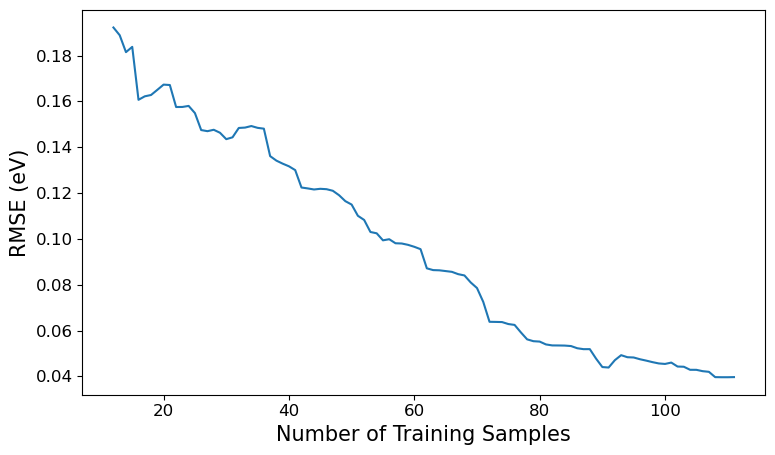

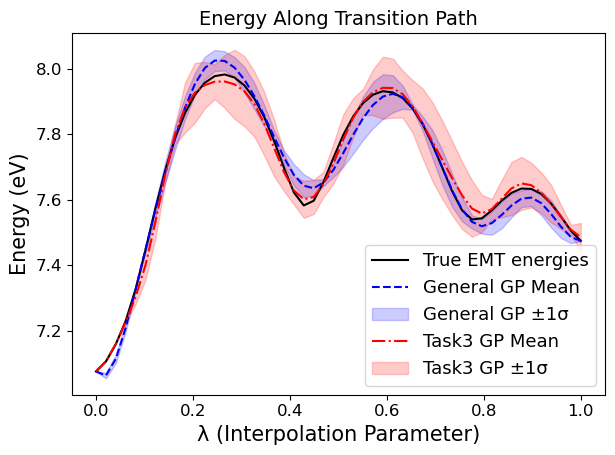

In [ ]:
# Task 4: Bayesian Optimization

# Domain boundaries from project description
x_min_b, x_max_b = 0.0, 16.65653
y_min_b, y_max_b = 0.0, 2.884996

X_grid,Y_grid,PES = np.load('pes_data.npz').values()

########################################
# Known global minimum from Task 1
########################################
x_min_global, y_min_global = 3.2867, 0.7237
pos_z = surface.positions[:,2].max() + 3
global_min_energy = calculate_adatom_energy(surface, [x_min_global, y_min_global, pos_z])
# Global minimum at x = 3.2867 Å, y = 0.7237 Å, E = 7.0761 eV

########################################
# Set up initial samples
# Include the known minima and some random points
########################################

np.random.seed(42)
num_initial_random = 10  # more than 5 to have a better starting coverage
X_random = np.column_stack([
    np.random.uniform(x_min_b, x_max_b, num_initial_random),
    np.random.uniform(y_min_b, y_max_b, num_initial_random)
])

# Add start (global minimum) and end points
x_end, y_end = 11.0, 2.1
X_init = np.vstack(( [ [x_min_global, y_min_global], [x_end, y_end] ], X_random ))
Y_init = np.array([calculate_adatom_energy(surface, [x, y, pos_z]) for x,y in X_init])[:,None]

########################################
# GP Model Setup with Priors (similar to Task 3)
########################################

k1 = GPy.kern.RBF(input_dim=2)
k1['lengthscale'].set_prior(GPy.priors.Gamma(a=2, b=1))
k1['variance'].set_prior(GPy.priors.Gamma(a=2, b=2))
k2 = GPy.kern.Bias(input_dim=2)
kernel = k1 + k2

model_general = GPy.models.GPRegression(X_init, Y_init, kernel)
#model_general.optimize_restarts(num_restarts=5, verbose=False)

########################################
# Acquisition Function (LCB) with large beta
# to encourage exploration
########################################

def lcb_acquisition(X, model, beta=10.0):  # larger beta for broader coverage
    mean, var = model.predict(X)
    std = np.sqrt(var)
    return -mean + beta * std

########################################
# Iteratively add samples to cover entire PES
# Increase max_iter and the number of candidates
########################################

max_iter = 100
num_candidates = 10000
X_train = model_general.X.copy()
Y_train = model_general.Y.copy()

rmse_history = []
for i in range(max_iter):
    # Re-optimize hyperparameters occasionally
    if i % 10 == 0:
        model_general.optimize_restarts(num_restarts=3, verbose=False)

    # Candidate points for acquisition
    candidate_x = np.random.uniform(x_min_b, x_max_b, num_candidates)
    candidate_y = np.random.uniform(y_min_b, y_max_b, num_candidates)
    candidates = np.column_stack((candidate_x, candidate_y))

    A_values = lcb_acquisition(candidates, model_general, beta=10.0)
    x_new = candidates[np.argmax(A_values)]
    E_new = calculate_adatom_energy(surface, [x_new[0], x_new[1], pos_z])
    Y_new = np.array([[E_new]])

    X_train = np.vstack((X_train, x_new))
    Y_train = np.vstack((Y_train, Y_new))
    model_general.set_XY(X_train, Y_train)

    # Compute RMSE over the entire PES from Task 1 for monitoring
    mean_pred, var_pred = model_general.predict(np.column_stack((X_grid.flatten(), Y_grid.flatten())))
    rmse = np.sqrt(np.mean((mean_pred.flatten() - PES.flatten())**2))
    rmse_history.append(rmse)

    # Optional early stopping if RMSE good enough:
    #if i > 50 and rmse_history[-1] < 0.05:
    #    print(f"Stopping early at iteration {i}, RMSE={rmse_history[-1]:.4f}")
    #    break

########################################
# Analyze RMSE vs Number of Samples
########################################

samples_count = np.arange(len(rmse_history)) + len(Y_init)
plt.figure().set_figwidth(8)
plt.plot(samples_count, rmse_history)
plt.xlabel('Number of Training Samples')
plt.ylabel('RMSE (eV)')
plt.tight_layout()
plt.savefig('rmse_vs_samples.pdf')
plt.show()

# Decide how many samples is "good" based on RMSE stabilization.

########################################
# Compare the GP model with Task 3 model
# Compute Energy along the linear path
########################################

num_points_path = 50
lambdas = np.linspace(0,1,num_points_path)
path_coords = np.array([ [x_min_global + lam*(x_end - x_min_global),
                          y_min_global + lam*(y_end - y_min_global)] for lam in lambdas ])

# True energies along path
true_energies = np.array([calculate_adatom_energy(surface, [xx, yy, pos_z]) for xx, yy in path_coords])

# Predictions from this general-purpose model
mean_general, var_general = model_general.predict(path_coords)
std_general = np.sqrt(var_general)

mean_general = mean_general.flatten()
std_general = std_general.flatten()

#Task 3 model as model_final:
mean_task3, var_task3 = model_final.predict(path_coords)
std_task3 = np.sqrt(var_task3)

mean_task3 = mean_task3.flatten()
std_task3 = std_task3.flatten()

# Plot results along the path
plt.figure()
plt.plot(lambdas, true_energies, 'k-', label='True EMT energies')
plt.plot(lambdas, mean_general, 'b--', label='General GP Mean')
plt.fill_between(lambdas, mean_general - std_general, mean_general + std_general,color='b', alpha=0.2, label='General GP ±1σ')

plt.plot(lambdas, mean_task3, 'r-.', label='Task3 GP Mean') 
std_task3_line = mean_task3 + std_task3
plt.fill_between(lambdas, mean_task3-std_task3, mean_task3+std_task3, color='r', alpha=0.2, label='Task3 GP ±1σ')

plt.xlabel('λ (Interpolation Parameter)')
plt.ylabel('Energy (eV)')
plt.title('Energy Along Transition Path')
plt.legend()
plt.tight_layout()
plt.savefig('energy_along_path.pdf')
plt.show()
